In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and preprocess train data

In [5]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

In [6]:
# delete rows where target == 0
dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data = ulsan_data.loc[ulsan_data['ulsan'] != 0]

## Load and preprocess test data (public LB)

In [7]:
sample_submission = pd.read_csv('../original_dataset/sample_submission.csv')

# 2월 일자만
sample_submission_feb = sample_submission.loc[sample_submission['time'].str.contains('2021-02')]
sample_submission_feb

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0
...,...,...,...,...,...
667,2021-02-28 20:00:00,0,0,0,0
668,2021-02-28 21:00:00,0,0,0,0
669,2021-02-28 22:00:00,0,0,0,0
670,2021-02-28 23:00:00,0,0,0,0


In [8]:
# load
with open('../witt_preprocessing/pickles/dangjin_fcst.pkl','rb') as f:
    dangjin = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_fcst.pkl','rb') as f:
    ulsan = pickle.load(f)

# index according to sample submission
start, end  = pd.Timestamp('2021-02-01 01:00:00'), pd.Timestamp('2021-03-01-00:00:00') # end == 2021-02-28 24:00:00

# slice test data
dangjin.set_index('time', inplace=True)
dangjin_feb = dangjin.loc[start:end,:]
print(dangjin_feb.shape)

ulsan.set_index('time', inplace=True)
ulsan_feb = ulsan.loc[start:end,:]
print(ulsan_feb.shape)

(672, 9)
(672, 9)


## train and validate

In [9]:
def validate(model, data, x_cols, y_cols):
    # input-taarget split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [19]:
dangjin_data.columns

Index(['Temperature_obs', 'Humidity_obs', 'Cloud_obs', 'Wind_X_obs',
       'Wind_Y_obs', 'Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst',
       'Wind_X_fcst', 'Wind_Y_fcst', 'Day_cos', 'Day_sin', 'Year_cos',
       'Year_sin', 'dangjin_sum'],
      dtype='object')

In [45]:
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

In [48]:
model = RandomForestRegressor(criterion='mae', verbose=2, n_jobs=-1, random_state=17, n_estimators=100)
dangjin_predict, dangjin_y = validate(model, dangjin_data, x_cols_obs, y_dangjin_cols)

<ipython-input-9-e1d6707ddbc9>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tre

Sum of error: 519922.80070709455


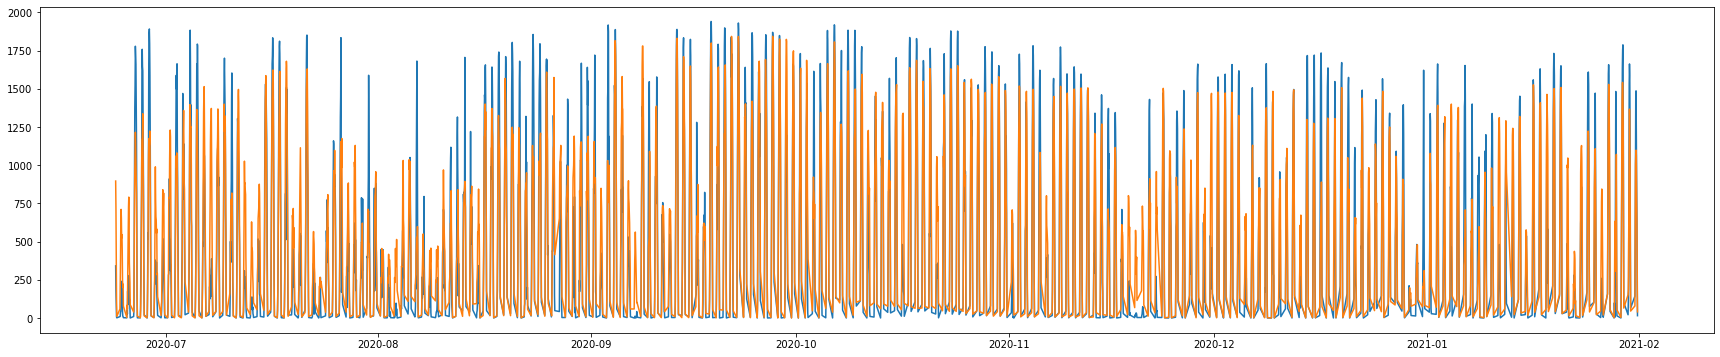

In [49]:
plt.figure(figsize=(30,6))

plt.plot(dangjin_y)

dangjin_predict_ = pd.Series(dangjin_predict, index=dangjin_y.index)
plt.plot(dangjin_predict_)

print('Sum of error:', abs(dangjin_predict_ - dangjin_y.iloc[:,0]).sum(axis=0))

# current best(random_state): 387441(10) / 389147(11) / 386676(12)
# config: 
# x= ['Temperature_fcst', 'Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']
# RandomForestRegressor(criterion='mae', verbose=2, n_jobs=-1, random_state=10, n_estimators=100)

## Config memos
### X
- obs보다 fcst가 좋다
- Wind_X와 Wind_Y는 제외하는 것이 좋다
- Temperature는 포함하는 것이 좋다
- Year_sin (시작점이 1월 1일)은 포함하는 것이 좋다

In [32]:
for i,x in enumerate(x_cols_fcst):
    print(x, end=' ') 
    print(model.feature_importances_[i])

Temperature_fcst 0.07757554990522526
Humidity_fcst 0.31293468603659147
Cloud_fcst 0.09218686018188145
Day_cos 0.20039262770249144
Day_sin 0.13647698814483572
Year_cos 0.11687284083077175
Year_sin 0.063560447198203


## for public LB

In [130]:
def predict(model, data, x_cols, y_cols, test_data):
    # input-taarget split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # fit
    model.fit(x,y)

    # predict
    predict = model.predict(test_data)

    return predict, model

In [131]:
model = RandomForestRegressor(criterion='mae', verbose=2, n_jobs=-1, random_state=518, n_estimators=100)

dangjin_predict, dangjin_model = predict(model, dangjin_data, x_cols_fcst, y_dangjin_cols, dangjin_feb)
ulsan_predict, ulsan_model = predict(model, ulsan_data, x_cols_fcst, y_ulsan_cols, ulsan_feb)

<ipython-input-130-8dd32d96f350>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x,y)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


## sample_submission.csv

In [139]:
(dangjin_predict + ulsan_predict).shape

(672,)

In [142]:
def to_submission(dangjin_predict, ulsan_predict):
    # sum (doesn't matter)
    predict = dangjin_predict + ulsan_predict
    # add
    sample_submission.iloc[:predict.shape[0],1] = predict
    # to csv
    sample_submission.to_csv('rf_single-timestep.csv', index=False)

    # confirm
    return pd.read_csv('rf_single-timestep.csv')

In [143]:
to_submission(dangjin_predict, ulsan_predict)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,7.31,0,0,0
1,2021-02-01 02:00:00,8.93,0,0,0
2,2021-02-01 03:00:00,9.03,0,0,0
3,2021-02-01 04:00:00,8.39,0,0,0
4,2021-02-01 05:00:00,10.44,0,0,0
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.00,0,0,0
1388,2021-07-08 21:00:00,0.00,0,0,0
1389,2021-07-08 22:00:00,0.00,0,0,0
1390,2021-07-08 23:00:00,0.00,0,0,0


## Random Forest Analysis

In [22]:
for i in range(ulsan_feb.shape[1]):
    print(ulsan_feb.columns[i], end=' ')
    print(ulsan_model.feature_importances_[i])

Temperature 0.11369518589772296
Humidity 0.0810689250066402
Cloud 0.17117927616268028
Wind_X 0.08601597482323153
Wind_Y 0.0821725116428837
Day_cos 0.2647148154892944
Day_sin 0.13118134882390112
Year_cos 0.034803040397196665
Year_sin 0.03516892175644919


In [23]:
for i in range(dangjin_feb.shape[1]):
    print(dangjin_feb.columns[i], end=' ')
    print(dangjin_model.feature_importances_[i])

Temperature 0.12158182039154453
Humidity 0.18736235535896276
Cloud 0.10521679741541402
Wind_X 0.07433916462737548
Wind_Y 0.08817991161518186
Day_cos 0.22656756964424832
Day_sin 0.12784589799538923
Year_cos 0.034066472377202825
Year_sin 0.03484001057468082
